In [124]:
import torch
import torchvision
import torch.optim as optim
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
from torch.utils.data import Dataset
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [125]:
torch.manual_seed(42)
np.random.seed(42)

NUMBER_NODES = 7
DATASET_PATH = f'../../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

In [126]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image / 255.0
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [127]:
training_data = CustomImageDataset(annotations_file='./annotations_file_train.csv', img_dir='./dataset_train_7')
val_data = CustomImageDataset(annotations_file='./annotations_file_val.csv', img_dir='./dataset_val_7')
test_data = CustomImageDataset(annotations_file='./annotations_file_test.csv', img_dir='./dataset_test_7')

In [128]:
BATCH_SIZE = 32
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [129]:
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
images[0].shape

torch.Size([3, 32, 32])

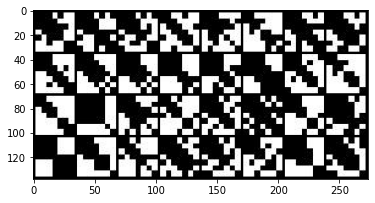

tensor(3) tensor(3) tensor(3) tensor(3) tensor(1) tensor(3) tensor(4) tensor(2) tensor(5) tensor(3) tensor(2) tensor(1) tensor(3) tensor(4) tensor(1) tensor(3) tensor(2) tensor(1) tensor(1) tensor(0) tensor(4) tensor(6) tensor(2) tensor(3) tensor(1) tensor(1) tensor(0) tensor(4) tensor(1) tensor(2) tensor(1) tensor(2)


In [130]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % labels[j] for j in range(BATCH_SIZE)))

In [131]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [132]:
# loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [133]:
def train(dataloader, model, optimizer):
    train_loss = 0
    for x, y in dataloader:
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return (train_loss / len(dataloader))

def validation(dataloader, model):
    val_loss = 0
    for X, y in dataloader:
        pred = model(X)
        loss = criterion(pred, y)
        val_loss += loss.item()

    return (val_loss / len(dataloader))

In [138]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding='same')
        # pool
        self.conv3 = nn.Conv2d(32, 64, 3, padding='same')
        # pool
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 7)

        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x1024 and 1728x128)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [139]:
epochs = 128

model = Net()

list_train_loss = []
list_val_loss = []

for epoch in range(epochs):
    train_loss = train(train_dataloader, model, optimizer)
    list_train_loss.append(train_loss)
    val_loss = validation(val_dataloader, model)
    list_val_loss.append(val_loss)
    print(f'Epoch {epoch + 1}, train_loss: {train_loss}, val_loss: {val_loss}')


Epoch 1, train_loss: 1.9433220360014174, val_loss: 1.9397507905960083
Epoch 2, train_loss: 1.9422781732347276, val_loss: 1.9397507905960083
Epoch 3, train_loss: 1.9423982478954174, val_loss: 1.9397507905960083
Epoch 4, train_loss: 1.9408658389691953, val_loss: 1.9397507905960083
Epoch 5, train_loss: 1.9406433017165572, val_loss: 1.9397507905960083
Epoch 6, train_loss: 1.9433491141707808, val_loss: 1.9397507905960083
Epoch 7, train_loss: 1.942286663585239, val_loss: 1.9397507905960083
Epoch 8, train_loss: 1.940844906700982, val_loss: 1.9397507905960083
Epoch 9, train_loss: 1.9433311488893297, val_loss: 1.9397507905960083
Epoch 10, train_loss: 1.9409262383425678, val_loss: 1.9397507905960083
Epoch 11, train_loss: 1.9405533870061238, val_loss: 1.9397507905960083
Epoch 12, train_loss: 1.9408360189861722, val_loss: 1.9397507905960083
Epoch 13, train_loss: 1.941331978197451, val_loss: 1.9397507905960083
Epoch 14, train_loss: 1.9431978861490886, val_loss: 1.9397507905960083
Epoch 15, train_lo

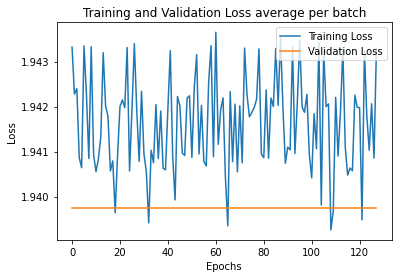

<Figure size 432x288 with 0 Axes>

In [140]:
plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss average per batch')
# plt.savefig(os.path.join(os.path.dirname(__file__), 'loss.jpg'))
plt.show()
plt.clf()

In [141]:
classes = [0, 1, 2, 3, 4, 5, 6]

dataiter = iter(test_dataloader)
images, labels = dataiter.next()

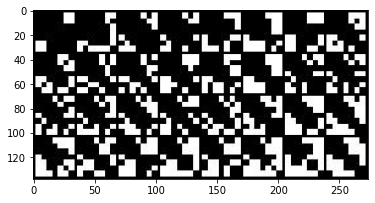

GroundTruth:  1 3 1 2


In [142]:
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [ ]:
outputs = net(images)

In [157]:
outputs

tensor([[-0.0505,  0.0922,  0.0235, -0.0694,  0.0384, -0.0097,  0.0065, -0.0687,
         -0.1312,  0.0181],
        [-0.0499,  0.0954,  0.0258, -0.0673,  0.0384, -0.0106,  0.0120, -0.0683,
         -0.1302,  0.0191],
        [-0.0529,  0.0926,  0.0255, -0.0716,  0.0393, -0.0073,  0.0052, -0.0675,
         -0.1293,  0.0122],
        [-0.0538,  0.0954,  0.0269, -0.0689,  0.0403, -0.0065,  0.0091, -0.0668,
         -0.1294,  0.0115],
        [-0.0540,  0.0940,  0.0234, -0.0723,  0.0409, -0.0057,  0.0103, -0.0624,
         -0.1264,  0.0111],
        [-0.0511,  0.0932,  0.0246, -0.0688,  0.0378, -0.0065,  0.0085, -0.0656,
         -0.1297,  0.0084],
        [-0.0518,  0.0931,  0.0275, -0.0739,  0.0415, -0.0113,  0.0110, -0.0736,
         -0.1266,  0.0165],
        [-0.0520,  0.0918,  0.0325, -0.0754,  0.0426, -0.0062,  0.0116, -0.0697,
         -0.1291,  0.0066],
        [-0.0539,  0.0917,  0.0316, -0.0777,  0.0419, -0.0078,  0.0111, -0.0699,
         -0.1277,  0.0070],
        [-0.0546,  

In [156]:
# print(outputs)
print(torch.max(outputs, 1))


torch.return_types.max(
values=tensor([0.0922, 0.0954, 0.0926, 0.0954, 0.0940, 0.0932, 0.0931, 0.0918, 0.0917,
        0.0874, 0.0898, 0.0906, 0.0909, 0.0895, 0.0908, 0.0912, 0.0899, 0.0888,
        0.0880, 0.0907, 0.0929, 0.0854, 0.0922, 0.0889, 0.0879, 0.0860, 0.0858,
        0.0838, 0.0801, 0.0828, 0.1002, 0.0822], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]))


In [144]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]}' for j in range(4)))

Predicted:  1 1 1 1
